<a href="https://colab.research.google.com/github/Aayush360/Fast_AI/blob/master/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install fastai --upgrade
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
path = untar_data(URLs.PETS)

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_97.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_34.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_167.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_116.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_22.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_154.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_147.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_153.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_121.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_82.jpg')...]

In [7]:
# extract breed name from the path
fname = (path/'images').ls()[0]
fname.name

'British_Shorthair_97.jpg'

In [8]:
re.findall(r'(.+)_\d+.jpg$',fname.name)

['British_Shorthair']

In [9]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter= RandomSplitter(seed=42),
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
                 item_tfms = Resize(460),
                 batch_tfms = aug_transforms(size=224,min_scale=0.75))
dls = pets.dataloaders(path/'images')

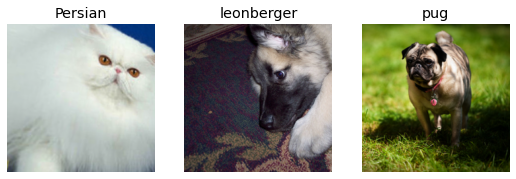

In [10]:
dls.show_batch(nrows=1,ncols=3)

In [11]:
# first train a simple model

In [12]:
learn=cnn_learner(dls,resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.523385,0.336367,0.107578,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.502362,0.301219,0.092693,01:05
1,0.326979,0.215961,0.059540,01:04


### Viewing activations and labels

In [13]:
# get the dependent and independent variable of one batch

x,y = dls.one_batch()

In [14]:
y.shape

torch.Size([64])

In [15]:
preds,_=learn.get_preds(dl=[(x,y)])

In [16]:
# contains 37 probabilty for a single image, probabilty with higher value resembles that class
preds[0]

tensor([2.7429e-07, 5.4062e-06, 7.7092e-06, 9.0714e-06, 1.2120e-06, 1.9803e-06, 2.0130e-05, 9.5592e-05, 2.8875e-05, 2.7998e-07, 4.6251e-07, 2.8678e-06, 3.0475e-06, 1.0567e-06, 8.3669e-07, 2.4314e-06,
        7.8327e-07, 4.8119e-06, 5.8496e-06, 6.8143e-06, 6.1137e-07, 3.5944e-05, 9.9912e-01, 4.0876e-05, 7.4477e-06, 8.0572e-07, 4.9631e-07, 4.6464e-06, 6.1875e-05, 4.3707e-06, 8.4823e-06, 4.7656e-05,
        1.1003e-05, 2.9668e-07, 7.1433e-07, 4.1302e-04, 4.5804e-05])

In [17]:
len(preds[0]), preds[0].sum()

(37, tensor(1.))

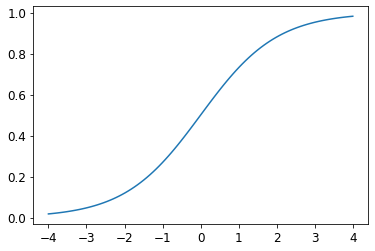

In [18]:
plot_function(torch.sigmoid, min=-4, max=4)

In [19]:
acts = torch.randn((6,2))*2
acts

tensor([[-0.9916, -2.2545],
        [ 0.1560, -1.9368],
        [-0.6164,  1.1047],
        [-2.0798, -2.1778],
        [ 1.6429, -3.7728],
        [-1.2445, -2.9512]])

In [20]:
acts.sigmoid()

tensor([[0.2706, 0.0950],
        [0.5389, 0.1260],
        [0.3506, 0.7511],
        [0.1111, 0.1018],
        [0.8379, 0.0225],
        [0.2237, 0.0497]])

In [21]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.7795, 0.8902, 0.1517, 0.5245, 0.9956, 0.8464])

In [22]:
# subracting two activation and taking a sigmoid is same as taking a softmax directly.

In [23]:
def softmax(x): return exp(x)/exp(x).sum(dim=1, keepdim=True)

In [24]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

In [25]:
# softmax is multicategory eqivalent of sigmoid

In [26]:
targ = tensor([0,1,0,1,1,0])

In [27]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.7795, 0.1098, 0.1517, 0.4755, 0.0044, 0.8464])

In [28]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.7795, -0.1098, -0.1517, -0.4755, -0.0044, -0.8464])

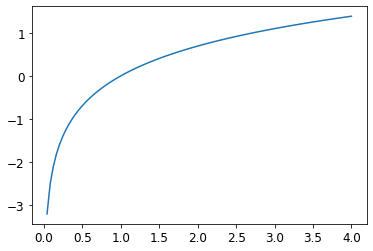

In [29]:
plot_function(torch.log, min=0, max=4) # not defined for numbers less than 0

In [30]:
loss_func = nn.CrossEntropyLoss()

In [31]:
loss_func(acts,targ)

tensor(1.7790)

In [32]:
F.cross_entropy(acts,targ)

tensor(1.7790)

In [33]:
nn.CrossEntropyLoss(reduction='none')(acts,targ)

tensor([0.2491, 2.2091, 1.8857, 0.7434, 5.4201, 0.1667])

## Model Interpretation

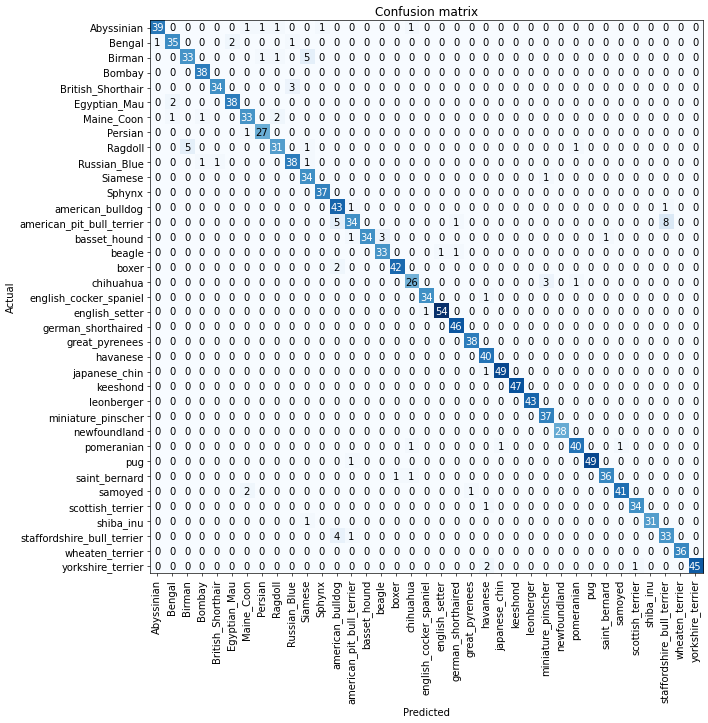

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [35]:
# to look at the most confused one

interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Birman', 'Siamese', 5),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5)]

## Improving our model

In [36]:
# the learning rate finder

In [37]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.582522,3.401760,0.391746,01:03


epoch,train_loss,valid_loss,error_rate,time
0,3.714343,2.449911,0.600812,01:05


In [38]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

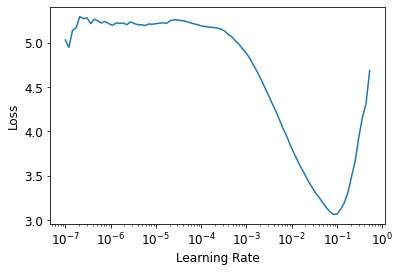

In [39]:
lr_min, lr_steep = learn.lr_find()

In [40]:
print(f"Minimum/10:{lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10:8.32e-03, steepest point: 7.59e-03


In [41]:
# let's choose the learning rate to be 3e-3, where the loss decreases steeply

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.292159,0.326326,0.094046,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.553742,0.414976,0.117050,01:04
1,0.332225,0.257382,0.079838,01:04


## Unfreezing and Transfer Learning

In [42]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3,3e-3) # trains the randomly added layers for 3 epochs with all other layers frozen

epoch,train_loss,valid_loss,error_rate,time
0,1.122673,0.296807,0.089986,01:02
1,0.533584,0.242551,0.076455,01:02
2,0.336415,0.214039,0.068336,01:02


In [43]:
learn.unfreeze()

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=6.309573450380412e-07)

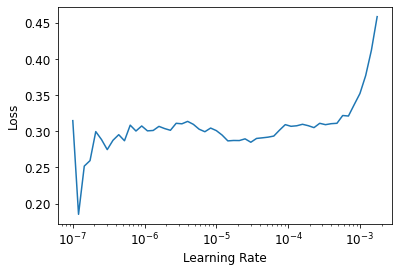

In [44]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(6,lr_max=1e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.179604,0.200939,0.061570,01:04
1,0.192463,0.199297,0.057510,01:04
2,0.170780,0.199441,0.057510,01:04
3,0.178332,0.196855,0.060217,01:04
4,0.177155,0.201254,0.057510,01:03
5,0.174188,0.198004,0.058863,01:04


## Descriminative Learning Rate

In [47]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3,3e-3) 
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.125614,0.382359,0.111637,01:02
1,0.511576,0.268312,0.086604,01:01
2,0.323866,0.226869,0.071042,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.267479,0.222190,0.069689,01:03
1,0.247330,0.211656,0.069012,01:04
2,0.229011,0.210030,0.066306,01:04
3,0.199950,0.202241,0.061570,01:04
4,0.188362,0.198942,0.060217,01:04
5,0.176560,0.198701,0.060893,01:06
6,0.157657,0.192270,0.057510,01:04
7,0.138263,0.192405,0.061570,01:04
8,0.135363,0.186166,0.054804,01:04
9,0.126186,0.184987,0.056834,01:04


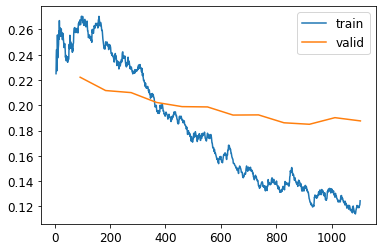

In [48]:
learn.recorder.plot_loss()

## Deeper Architecture

In [51]:
# to support feature called tensor core which could dramatically speed up neural network training (use mixed precision training)

from fastai.callback.fp16 import *
learn = cnn_learner(dls,resnet50,metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.414347,0.320782,0.100135,01:08
1,0.628645,0.322720,0.095399,01:06
2,0.426131,0.304473,0.094046,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.276464,0.235712,0.070365,01:08
1,0.323747,0.399934,0.114344,01:09
2,0.247543,0.279053,0.072395,01:08
3,0.155762,0.234246,0.064276,01:07
4,0.085546,0.216597,0.060893,01:08
5,0.062671,0.210834,0.058863,01:08
